In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Excelr Projects/Apple stock prediction/AAPL.csv')

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100
...,...,...,...,...,...,...,...
2006,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000
2007,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700
2008,2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300
2009,2019-12-27,291.119995,293.970001,288.119995,289.799988,287.814392,36566500


In [ ]:
df.Date = pd.to_datetime(df.Date)
df = df[['Date','Close']].set_index(['Date'])
df

,Close
Date,
2012-01-03,58.747143
2012-01-04,59.062859
2012-01-05,59.718571
2012-01-06,60.342857
2012-01-09,60.247143
...,...
2019-12-23,284.000000
2019-12-24,284.269989
2019-12-26,289.910004


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2011 entries, 2012-01-03 to 2019-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2011 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB


In [ ]:
resampled = df.resample('M').mean()

<ipython-input-6-b450d1e8bf80>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = df.resample('M').mean()


In [ ]:
resampled

,Close
Date,
2012-01-31,61.225428
2012-02-29,71.081572
2012-03-31,82.501104
2012-04-30,86.571857
2012-05-31,80.667597
...,...
2019-08-31,204.957728
2019-09-30,217.994999
2019-10-31,235.286521


<Axes: xlabel='Date'>

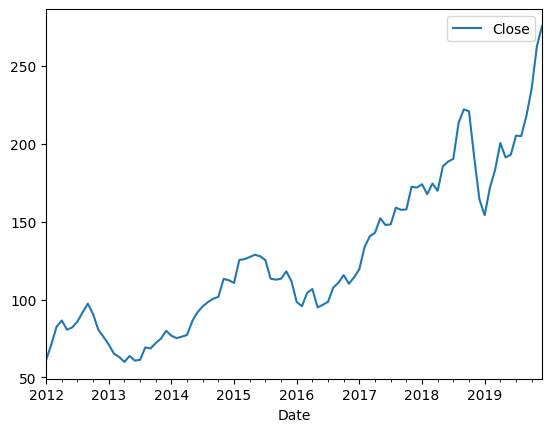

In [ ]:
resampled.plot()

<ipython-input-9-b4e4c69e6469>:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df.resample('Q').mean().plot()


<Axes: xlabel='Date'>

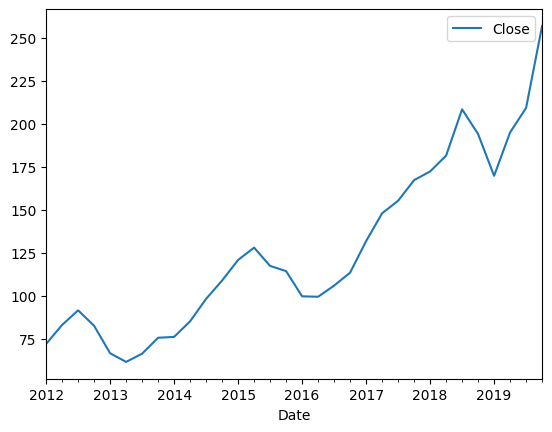

In [ ]:
df.resample('Q').mean().plot()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

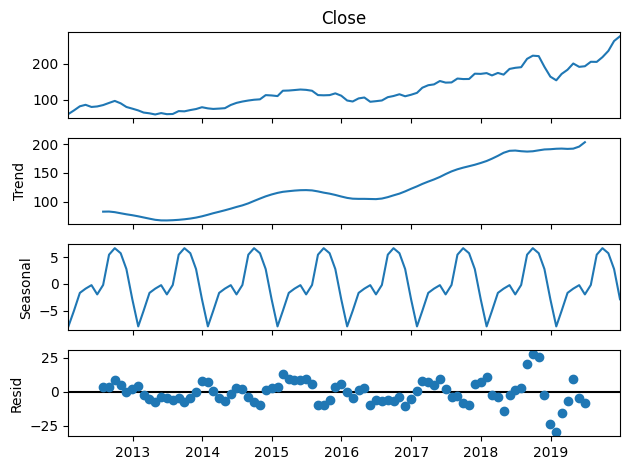

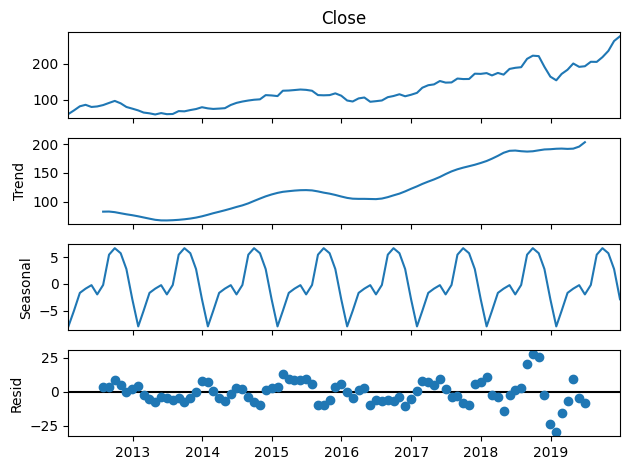

In [ ]:
seasonal_decompose(resampled['Close'], period=12).plot()

### If residuals show a pattern, it means some trend/seasonality is still present.

## There is an upward trend

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
res = adfuller(resampled['Close'], autolag='AIC')
res[1]

0.9852365602721007

### p-value(0.985) > 0.05 ==> Accept null Hypothesis i.e the time-series data is non-stationary

## Converting the data to stationary

### Log Transformation for reducing variance

<Axes: xlabel='Date'>

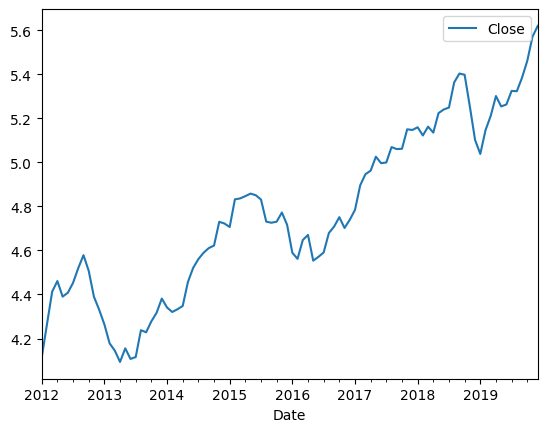

In [ ]:
log_trans = np.log(resampled)
log_trans.plot()

In [ ]:
res = adfuller(log_trans['Close'], autolag='AIC')
res[1]

0.9347103046620191

### p-value(0.934) > 0.05 ==> Accept null Hypothesis i.e the time-series data is non-stationary


In [ ]:
print(f"Variance: {log_trans.var().values[0]}")

Variance: 0.15249246114739043


### Differencing 1 time to remove trend.

In [ ]:
diff_1 = log_trans.diff().dropna()

res = adfuller(diff_1['Close'], autolag='AIC')
print(f"p-value: {res[1]:.16f}")

p-value: 0.0000000002888852


### p-value(0.0000000086604129) < 0.05 ==> Reject null Hypothesis i.e the time-series data is stationary

<Axes: xlabel='Date'>

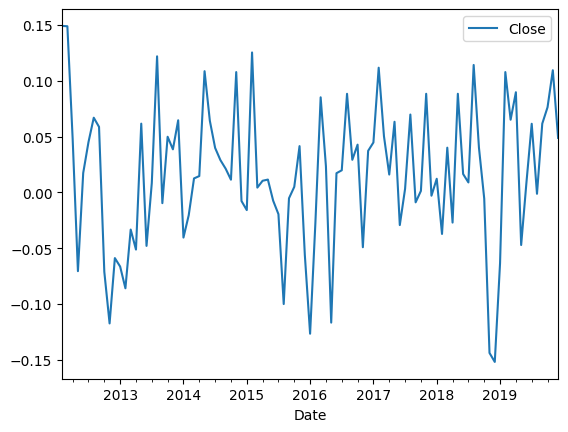

In [ ]:
diff_1.plot()

In [ ]:
diff_1.var().values[0]

0.004117265395964156

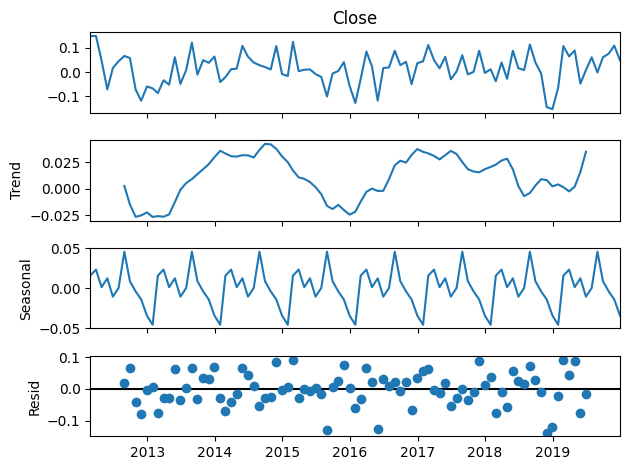

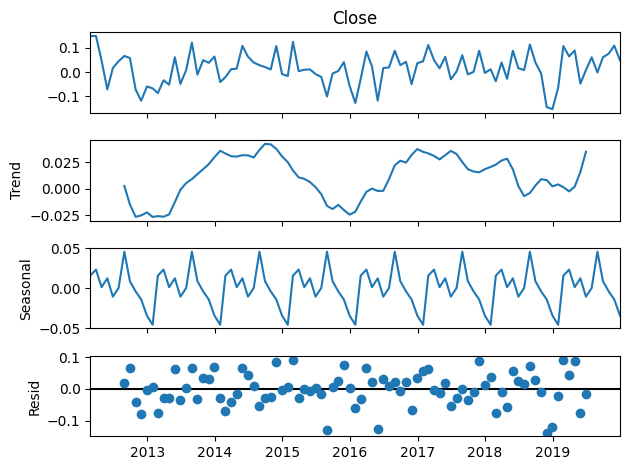

In [ ]:
seasonal_decompose(diff_1['Close'], period=12).plot()

### Residuals are Random: The residuals should look like white noise (random scatter around zero). This suggests most of the structure has been captured

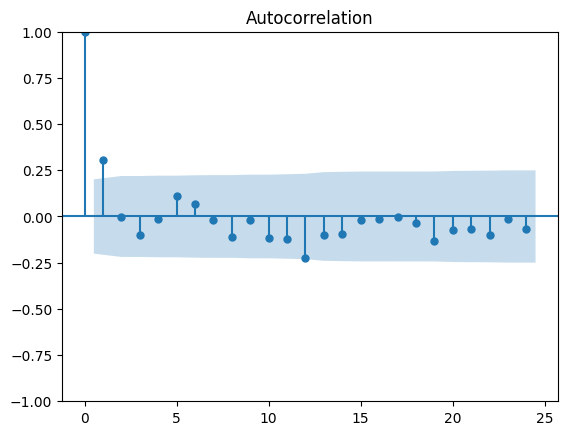

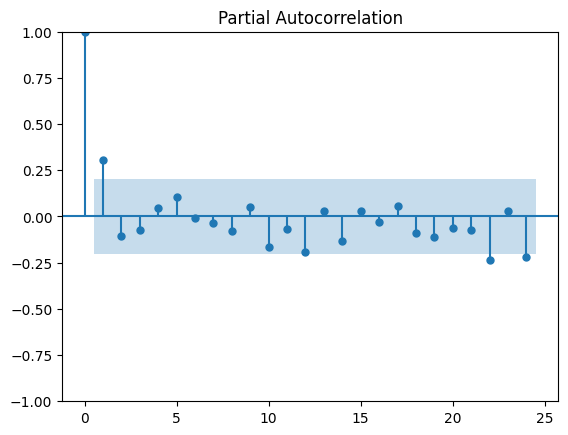

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_1['Close'], lags=24)  # Check seasonal lags (e.g., 12 for yearly seasonality)
plot_pacf(diff_1['Close'], lags=24)
plt.show()

### **Interpretation of the PACF Plot:**
- There is a strong correlation at **lag 1**, which indicates short-term dependencies.
- After lag 1, the correlations drop and remain within the confidence interval (shaded region), meaning there are no significant longer-term patterns.
- So we will take p = 1.

### **Interpretation of the ACF Plot:**
- The plot shows significant autocorrelations at lags 1, indicated by bars extending beyond the blue shaded area, but autocorrelations become insignificant after lag 1. So q = 1.

In [ ]:
import seaborn as sns

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing as statsspace_ES

## ARIMA

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.6 MB/s eta 0:00:00


In [ ]:
train = resampled.loc[ resampled.index <= '2018-12-31']

In [ ]:
test = resampled.loc[ resampled.index > '2018-12-31']

In [ ]:
from pmdarima import auto_arima
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
arima_model = auto_arima(train,
                  start_p=0, max_p=5,
                  start_q=0, max_q=5,
                  d=None,  # Let the model find d
                  seasonal=False,  # If your data is not seasonal
                  stepwise=True,  # Use a stepwise search for efficiency
                  trace=True,  # Print the models being evaluated
                  suppress_warnings=True)

# Print the best model summary
print(arima_model.summary())

# Make predictions
arima_predictions = arima_model.predict(n_periods=12)

################ SARIMA
sarima_model = auto_arima(train,
                  start_p=0, max_p=5,
                  start_q=0, max_q=5,
                  d=None,  # Let the sarima_model find d
                  seasonal=True,  # If your data is not seasonal
                  stepwise=True,  # Use a stepwise search for efficiency
                  trace=True,  # Print the sarima_models being evaluated
                  suppress_warnings=True,
                 m=12
                   )

# Print the best sarima_model summary
print(sarima_model.summary())

# Make predictions
sarima_predictions = sarima_model.predict(n_periods=12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=583.134, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=576.787, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=576.688, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=583.147, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=578.427, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=578.227, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=580.186, Time=0.86 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=575.871, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=577.365, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=577.113, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=575.575, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=577.253, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=579.004, Time=0.62 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.106 seconds
                               SARI

### Both ARIMA(1,1,0)(AIC=575.575) and SARIMA(1,1,0)(AIC=575.575) are performing same

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
train_mape=[]
test_mape=[]
model = []

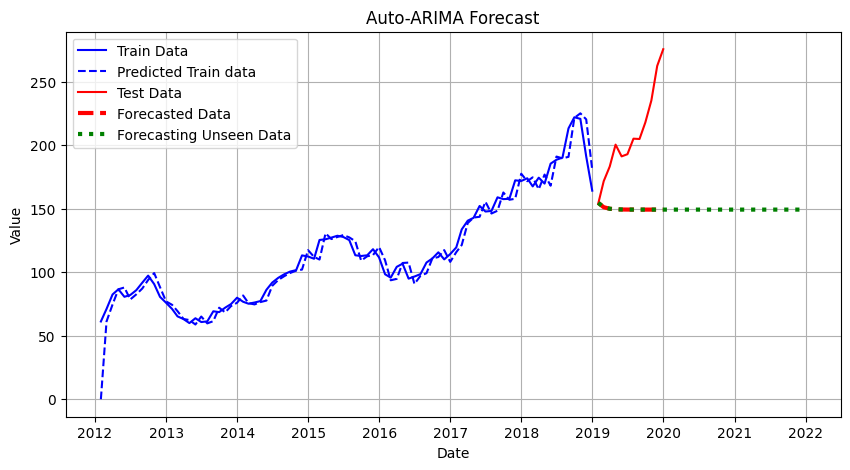

In [ ]:
# print("MAPE:", mean_absolute_percentage_error(train.Close, arima_model.predict_in_sample().values)  )
# Plot Actual Data

model.append("ARIMA")
train_mape.append( mean_absolute_percentage_error(train.Close, arima_model.predict_in_sample().values) )
test_mape.append( mean_absolute_percentage_error(test.Close, arima_predictions) )

plt.figure(figsize=(10, 5))

plt.plot(train.index, train, label="Train Data", linestyle='-',color='blue')
plt.plot(train.index, arima_model.predict_in_sample(), label="Predicted Train data", linestyle='dashed', color='blue')

plt.plot(test.index, test, label="Test Data", linestyle='-',color='red')

# Plot Forecasted Data
plt.plot(arima_predictions.index, arima_predictions, label="Forecasted Data", linestyle='dashed', color='red', lw='3')

plt.plot(arima_model.predict(36).index, arima_model.predict(36), label="Forecasting Unseen Data", linestyle=':', color='green', lw='3')

# Formatting
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Auto-ARIMA Forecast")
plt.legend()
plt.grid(True)
plt.show()

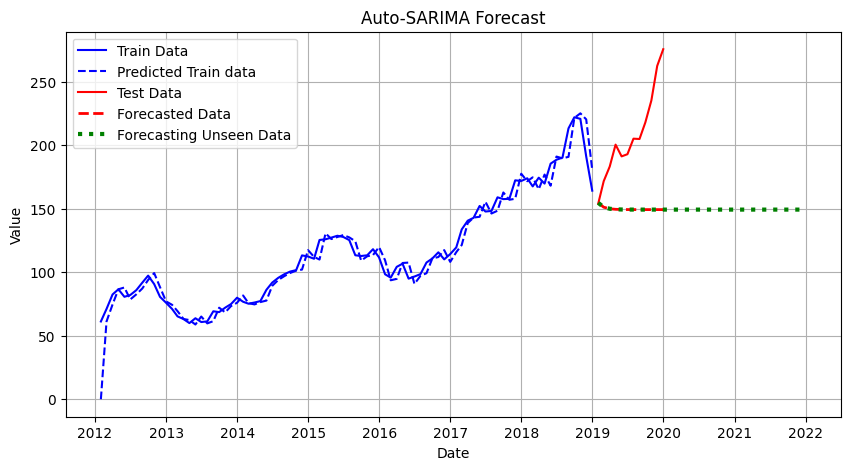

In [ ]:
model.append("SARIMA")
train_mape.append( mean_absolute_percentage_error(train.Close, sarima_model.predict_in_sample().values) )
test_mape.append( mean_absolute_percentage_error(test.Close, sarima_predictions) )

# Plot Actual Data
plt.figure(figsize=(10, 5))

plt.plot(train.index, train, label="Train Data", linestyle='-', color='blue')
plt.plot(train.index, sarima_model.predict_in_sample(), label="Predicted Train data", linestyle='dashed', color='blue')

plt.plot(test.index, test, label="Test Data", linestyle='-',color='red')

# Plot Forecasted Data
plt.plot(sarima_predictions.index, sarima_predictions, label="Forecasted Data", linestyle='dashed', color='red', lw='2')

plt.plot(sarima_model.predict(36).index, sarima_model.predict(36), label="Forecasting Unseen Data", linestyle=':', color='green', lw='3')


# Formatting
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Auto-SARIMA Forecast")
plt.legend()
plt.grid(True)
plt.show()

### Simple Exponential Smoothing (SES) - No trend, No seasonality

MAPE: 35.731331820747485


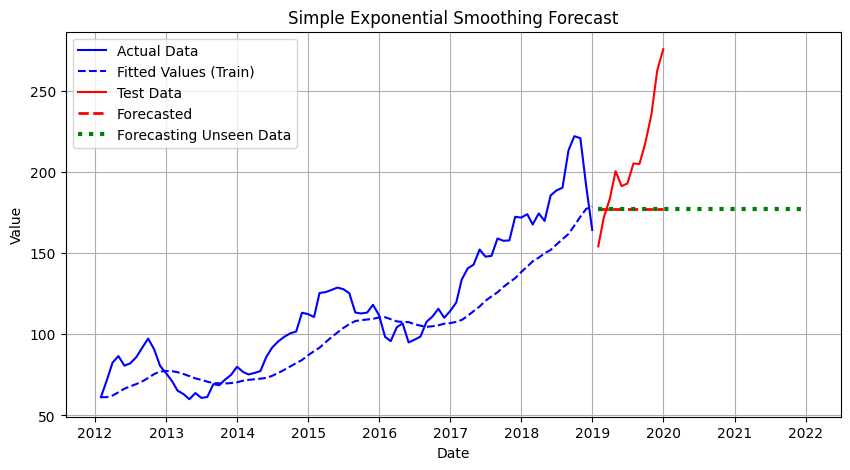

In [ ]:
mape_score = 400
for i in [round(x, 1) for x in np.arange(0.1, 1.0, 0.1)]:
    ses_model = SimpleExpSmoothing(train.Close).fit(smoothing_level=i)
    y_hat = ses_model.predict(start=train.index[0], end=train.index[-1])
    if mean_absolute_percentage_error(train, y_hat)<mape_score:
        best_ses_model = ses_model
        mape_score = mean_absolute_percentage_error(train, y_hat)
pred = best_ses_model.forecast(12)
print("MAPE:",mape_score)
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Actual Data", linestyle='-',color='blue')
plt.plot(train.index, best_ses_model.predict(start=train.index[0], end=train.index[-1]), label="Fitted Values (Train)", linestyle="--", color="blue")

plt.plot(test.index, test, label="Test Data", linestyle='-', color='red')
# Plot Forecasted Data
plt.plot(pred.index, pred, label="Forecasted", linestyle='dashed', color='red', lw='2')

plt.plot(best_ses_model.forecast(36).index, best_ses_model.forecast(36), label="Forecasting Unseen Data", linestyle=':', color='green', lw='3')

# Formatting
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Simple Exponential Smoothing Forecast")
plt.legend()
plt.grid(True)
plt.show()

model.append("Simple Exponential Smoothing")
train_mape.append( mean_absolute_percentage_error(train.Close, best_ses_model.predict(start=train.index[0], end=train.index[-1]) ) )
test_mape.append( mean_absolute_percentage_error(test.Close, pred) )

### Holt method - Trend but No Seasonality

MAPE: 39.41635269334975


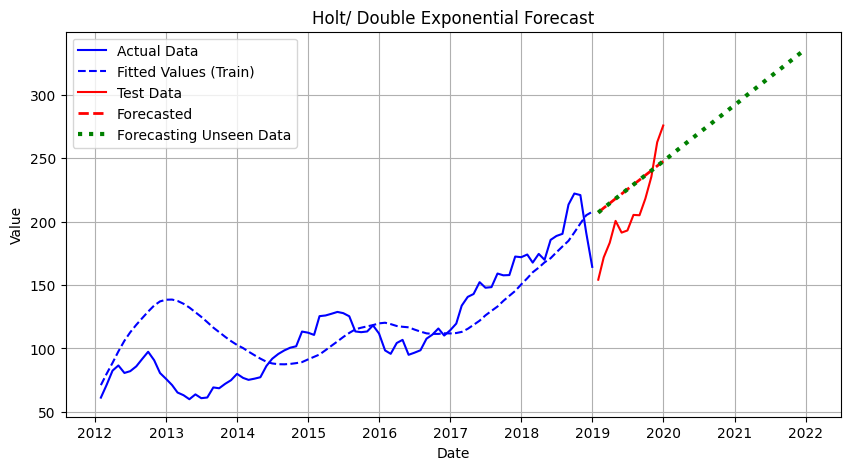

In [ ]:
mape_score = 99999
for i in [round(x, 1) for x in np.arange(0.1, 1.0, 0.1)]:
    for j in [round(x, 1) for x in np.arange(0.1, 1.0, 0.1)]:
        holt_model = Holt(train.Close).fit(smoothing_level=i, smoothing_slope=j)
        y_hat = holt_model.predict(start=train.index[0], end=train.index[-1])
        if mean_absolute_percentage_error(train, y_hat)<mape_score:
            best_holt_model = holt_model
            mape_score = mean_absolute_percentage_error(train, y_hat)
pred = best_holt_model.forecast(12)
print("MAPE:",mape_score)
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Actual Data", linestyle='-',color='blue')
plt.plot(train.index, best_holt_model.predict(start=train.index[0], end=train.index[-1]), label="Fitted Values (Train)", linestyle="--", color="blue")

plt.plot(test.index, test, label="Test Data", linestyle='-',color='red')
# Plot Forecasted Data
plt.plot(pred.index, pred, label="Forecasted", linestyle='dashed', color='red', lw='2')

plt.plot(best_holt_model.forecast(36).index, best_holt_model.forecast(36), label="Forecasting Unseen Data", linestyle=':', color='green', lw='3')

# Formatting
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Holt/ Double Exponential Forecast")
plt.legend()
plt.grid(True)
plt.show()

model.append("Holt method")
train_mape.append( mean_absolute_percentage_error(train.Close, best_holt_model.predict(start=train.index[0], end=train.index[-1]) ) )
test_mape.append( mean_absolute_percentage_error(test.Close, pred) )

### Holt-Winters Seasonal Model - Trend + Seasonality

MAPE: 42.17558879281482


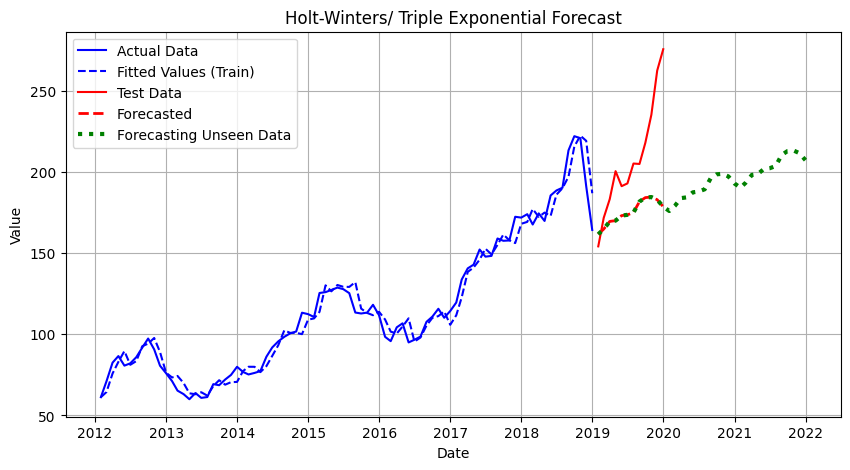

In [ ]:
mape_score = 99999
for i in ['add', 'mul']:
    for j in ['add', 'mul']:
        HW_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).fit()
        y_hat = HW_model.predict(start=train.index[0], end=train.index[-1])
        if mean_absolute_percentage_error(train, y_hat)<mape_score:
            best_HW_model = HW_model
            mape_score = mean_absolute_percentage_error(train, y_hat)
pred = best_HW_model.forecast(12)
print("MAPE:",mape_score)
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Actual Data", linestyle='-',color='blue')
plt.plot(train.index, best_HW_model.predict(start=train.index[0], end=train.index[-1]), label="Fitted Values (Train)", linestyle="--", color="blue")

plt.plot(test.index, test, label="Test Data", linestyle='-', color='red')
# Plot Forecasted Data
plt.plot(pred.index, pred, label="Forecasted", linestyle='dashed', color='red', lw='2')

plt.plot(best_HW_model.forecast(36).index, best_HW_model.forecast(36), label="Forecasting Unseen Data", linestyle=':', color='green', lw='3')

# Formatting
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Holt-Winters/ Triple Exponential Forecast")
plt.legend()
plt.grid(True)
plt.show()

model.append("Holt-Winters Seasonal Model")
train_mape.append( mean_absolute_percentage_error(train.Close, best_HW_model.predict(start=train.index[0], end=train.index[-1]) ) )
test_mape.append( mean_absolute_percentage_error(test.Close, pred) )

In [ ]:
pd.DataFrame({
    'Model': model,
    'train': train_mape,
    'test': test_mape,
    'avg_mape': [ (i+j)/2 for i,j in zip(train_mape, test_mape) ]
}).sort_values(by='avg_mape')

,Model,train,test,avg_mape
4,Holt-Winters Seasonal Model,4.571560,14.974083,9.772822
2,Simple Exponential Smoothing,14.249886,15.604061,14.926974
0,ARIMA,5.928136,25.963995,15.946065
1,SARIMA,5.928136,25.963995,15.946065
3,Holt method,25.948046,14.044759,19.996402


### Holt-Winters Seasonal Model	is performing well.

In [ ]:
import pickle

# Save object to a file
with open('best_HW_model.pkl', 'wb') as f:
    pickle.dump(best_HW_model, f)
